### Creating and training the shallow, deep, and SE models on FER-2013

See the other notebooks for the improved SE model and for the RAF-DB training.

In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization, GlobalAveragePooling2D, ReLU, Multiply, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, Dropout, MaxPooling2D, Flatten, Dense
from tensorflow.keras.regularizers import l2


import matplotlib.pyplot as plt

2024-03-22 00:43:42.098543: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
# more data augmentation compared to the paper; adapted from https://github.com/hujie-frank/SENet
# different dataset than the paper
train_data_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    horizontal_flip=True,
    rotation_range=10,
    width_shift_range=0.08,
    height_shift_range=0.08,
    brightness_range=[0.8, 1.2],
    zoom_range=[0.92, 1.08],
    fill_mode='nearest'
)

train_generator = train_data_gen.flow_from_directory(
    'datasets/FER-2013/train',
    target_size=(48, 48),
    batch_size=32,
    color_mode='grayscale',
    class_mode='categorical',
    subset='training'
)

validation_generator = train_data_gen.flow_from_directory(
    'datasets/FER-2013/train',
    target_size=(48, 48),
    batch_size=32,
    color_mode='grayscale',
    class_mode='categorical',
    subset='validation'
)

test_data_gen = ImageDataGenerator(rescale=1./255)

test_generator = test_data_gen.flow_from_directory(
    'datasets/FER-2013/test',
    target_size=(48, 48),
    batch_size=32,
    color_mode='grayscale',
    class_mode='categorical'
)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [5]:
# shallow model, as described in the paper
# paper does not specify how much dropout
# Model initialization
model = Sequential()

# Convolutional layers
model.add(Conv2D(32, (3, 3), padding='same', input_shape=(48, 48, 1), kernel_regularizer=l2(1e-6)))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(1e-6)))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flatten the output
model.add(Flatten())

# Dense layer with L2 regularization
model.add(Dense(512, kernel_regularizer=l2(1e-6)))
model.add(ReLU())
model.add(Dropout(0.5))

# Output layer
model.add(Dense(7, activation='softmax'))

# Compile the model
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

2024-03-22 00:44:57.743707: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10398 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:04:00.0, compute capability: 6.1


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 batch_normalization (Batch  (None, 48, 48, 32)        128       
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 48, 48, 32)        0         
                                                                 
 dropout (Dropout)           (None, 48, 48, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 48, 48, 64)        256       
 chNormalization)                                       

In [6]:
# Train the model
shallow_model_history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // 32
)

Epoch 1/30


2024-03-22 00:45:03.103132: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-03-22 00:45:03.851673: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-03-22 00:45:04.598624: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f736800eef0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-22 00:45:04.598726: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2024-03-22 00:45:04.611324: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-22 00:45:04.876853: I ./tensorflow/compiler/jit/device_compiler.h:186] C

717/717 [==============================] - 57s 73ms/step - loss: 1.9625 - accuracy: 0.2236 - val_loss: 1.7823 - val_accuracy: 0.2877
Epoch 2/30
717/717 [==============================] - 36s 50ms/step - loss: 1.8038 - accuracy: 0.2557 - val_loss: 1.7571 - val_accuracy: 0.2902
Epoch 3/30
717/717 [==============================] - 35s 48ms/step - loss: 1.7819 - accuracy: 0.2671 - val_loss: 1.7362 - val_accuracy: 0.2912
Epoch 4/30
717/717 [==============================] - 37s 52ms/step - loss: 1.7706 - accuracy: 0.2725 - val_loss: 1.7271 - val_accuracy: 0.3066
Epoch 5/30
717/717 [==============================] - 35s 49ms/step - loss: 1.7561 - accuracy: 0.2813 - val_loss: 1.6940 - val_accuracy: 0.3090
Epoch 6/30
717/717 [==============================] - 35s 49ms/step - loss: 1.7395 - accuracy: 0.2887 - val_loss: 1.6904 - val_accuracy: 0.3341
Epoch 7/30
717/717 [==============================] - 35s 48ms/step - loss: 1.7230 - accuracy: 0.2939 - val_loss: 1.6903 - val_accuracy: 0.3019
Epo

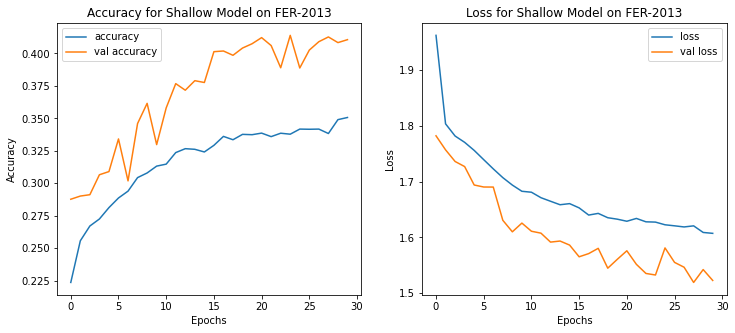

In [8]:
shallow_accuracy = shallow_model_history.history['accuracy']
shallow_val_accuracy = shallow_model_history.history['val_accuracy']
shallow_loss = shallow_model_history.history['loss']
shallow_val_loss = shallow_model_history.history['val_loss']

plt.figure(figsize=(12, 5))

# accuracy graph
plt.subplot(1, 2, 1)
plt.plot(shallow_accuracy, label='accuracy')
plt.plot(shallow_val_accuracy, label='val accuracy')
plt.title('Accuracy for Shallow Model on FER-2013')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# loss graph
plt.subplot(1, 2, 2)
plt.plot(shallow_loss, label='loss')
plt.plot(shallow_val_loss, label='val loss')
plt.title('Loss for Shallow Model on FER-2013')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

My shallow model has lower accuracy than the paper's, but I'm also training on a different dataset. It's honestly unclear what dataset the paper is using ("a dataset from Kaggle").

In [9]:
# deeper model, structured after the paper

deeper_model = Sequential()

# Convolutional Layer 1
deeper_model.add(Conv2D(64, (3, 3), strides=(1, 1), padding='same', input_shape=(48, 48, 1), kernel_regularizer=l2(1e-6)))
deeper_model.add(BatchNormalization())
deeper_model.add(ReLU())
deeper_model.add(MaxPooling2D(pool_size=(2, 2)))
deeper_model.add(Dropout(0.25))

# Convolutional Layer 2
deeper_model.add(Conv2D(128, (5, 5), strides=(1, 1), padding='same', kernel_regularizer=l2(1e-6)))
deeper_model.add(BatchNormalization())
deeper_model.add(ReLU())
deeper_model.add(MaxPooling2D(pool_size=(2, 2)))
deeper_model.add(Dropout(0.25))

# Convolutional Layer 3
deeper_model.add(Conv2D(512, (3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(1e-6)))
deeper_model.add(BatchNormalization())
deeper_model.add(ReLU())
deeper_model.add(MaxPooling2D(pool_size=(2, 2)))
deeper_model.add(Dropout(0.25))

# Convolutional Layer 4
deeper_model.add(Conv2D(512, (3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(1e-6)))
deeper_model.add(BatchNormalization())
deeper_model.add(ReLU())
deeper_model.add(MaxPooling2D(pool_size=(2, 2)))
deeper_model.add(Dropout(0.25))

# Flatten the output to feed into the Dense layers
deeper_model.add(Flatten())

# Fully Connected Layer 1
deeper_model.add(Dense(256, kernel_regularizer=l2(1e-6)))
deeper_model.add(BatchNormalization())
deeper_model.add(ReLU())
deeper_model.add(Dropout(0.5))

# Fully Connected Layer 2
deeper_model.add(Dense(512, kernel_regularizer=l2(1e-6)))
deeper_model.add(BatchNormalization())
deeper_model.add(ReLU())
deeper_model.add(Dropout(0.5))

# Output Layer
deeper_model.add(Dense(7, activation='softmax'))

# Compile the model with a specified learning rate
optimizer = Adam(learning_rate=0.001)
deeper_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Model Summary
deeper_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_2 (Bat  (None, 48, 48, 64)        256       
 chNormalization)                                                
                                                                 
 re_lu_3 (ReLU)              (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 24, 24, 64)        0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 24, 24, 64)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 24, 24, 128)      

In [10]:
deeper_model_history = deeper_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // 32
)


Epoch 1/30


2024-03-22 01:08:20.037993: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_3/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


717/717 [==============================] - 57s 70ms/step - loss: 2.0098 - accuracy: 0.2262 - val_loss: 1.7379 - val_accuracy: 0.3076
Epoch 2/30
717/717 [==============================] - 36s 50ms/step - loss: 1.7067 - accuracy: 0.3244 - val_loss: 1.6086 - val_accuracy: 0.3764
Epoch 3/30
717/717 [==============================] - 35s 49ms/step - loss: 1.5221 - accuracy: 0.4097 - val_loss: 1.5887 - val_accuracy: 0.3755
Epoch 4/30
717/717 [==============================] - 34s 47ms/step - loss: 1.4217 - accuracy: 0.4525 - val_loss: 1.4235 - val_accuracy: 0.4571
Epoch 5/30
717/717 [==============================] - 33s 46ms/step - loss: 1.3605 - accuracy: 0.4826 - val_loss: 1.3668 - val_accuracy: 0.4581
Epoch 6/30
717/717 [==============================] - 34s 48ms/step - loss: 1.3154 - accuracy: 0.5029 - val_loss: 1.2521 - val_accuracy: 0.5255
Epoch 7/30
717/717 [==============================] - 34s 47ms/step - loss: 1.2935 - accuracy: 0.5140 - val_loss: 1.3484 - val_accuracy: 0.4831
Epo

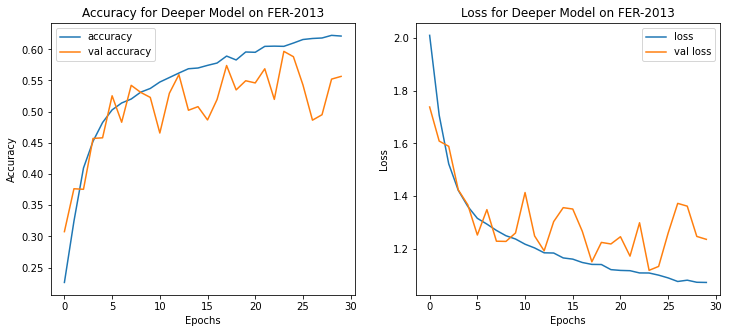

In [12]:
accuracy = deeper_model_history.history['accuracy']
val_accuracy = deeper_model_history.history['val_accuracy']
loss = deeper_model_history.history['loss']
val_loss = deeper_model_history.history['val_loss']

plt.figure(figsize=(12, 5))

# accuracy graph
plt.subplot(1, 2, 1)
plt.plot(accuracy, label='accuracy')
plt.plot(val_accuracy, label='val accuracy')
plt.title('Accuracy for Deeper Model on FER-2013')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# loss graph
plt.subplot(1, 2, 2)
plt.plot(loss, label='loss')
plt.plot(val_loss, label='val loss')
plt.title('Loss for Deeper Model on FER-2013')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Add attention with SE blocks

In [13]:
# add attention

def squeeze_excite_block(input_tensor, ratio=16):
    init = input_tensor
    channel_axis = -1
    filters = init.shape[channel_axis]

    se = GlobalAveragePooling2D()(init)
    se = Dense(filters // ratio, activation='relu', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', use_bias=False)(se)
    se = Reshape((1, 1, filters))(se)
    x = Multiply()([init, se])
    return x

# Model definition, use Functional API instead of Sequential
input_img = Input(shape=(48, 48, 1))

# 1st conv block
x = Conv2D(64, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(1e-6))(input_img)
x = ReLU()(x)
x = BatchNormalization()(x)
x = squeeze_excite_block(x)

# 2nd conv block
x = Conv2D(128, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(1e-6))(x)
x = ReLU()(x)
x = BatchNormalization()(x)
x = squeeze_excite_block(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)

# 3rd conv block
x = Conv2D(512, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(1e-6))(x)
x = ReLU()(x)
x = BatchNormalization()(x)
x = squeeze_excite_block(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# 4th conv block
x = Conv2D(512, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(1e-6))(x)
x = ReLU()(x)
x = BatchNormalization()(x)
x = squeeze_excite_block(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)

# Flatten and Dense Layers
x = Flatten()(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(1e-6))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Additional Dense layer to increase complexity
x = Dense(512, activation='relu', kernel_regularizer=l2(1e-6))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Output layer
output = Dense(7, activation='softmax')(x)

model = Model(inputs=input_img, outputs=output)


# Set up the learning rate schedule and compile the model
initial_learning_rate = 0.0001
lr_schedule = ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

optimizer = Adam(learning_rate=lr_schedule)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 48, 48, 1)]          0         []                            
                                                                                                  
 conv2d_6 (Conv2D)           (None, 48, 48, 64)           640       ['input_1[0][0]']             
                                                                                                  
 re_lu_9 (ReLU)              (None, 48, 48, 64)           0         ['conv2d_6[0][0]']            
                                                                                                  
 batch_normalization_8 (Bat  (None, 48, 48, 64)           256       ['re_lu_9[0][0]']             
 chNormalization)                                                                             

In [14]:
model_info = model.fit(
        train_generator,
        steps_per_epoch=22968 // 32, # number of training data divided by batch size
        epochs=30,
        validation_data=validation_generator,
        validation_steps=5741 // 32)

Epoch 1/30


2024-03-22 01:32:19.001374: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_9/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


717/717 [==============================] - 63s 78ms/step - loss: 2.6857 - accuracy: 0.2011 - val_loss: 1.9418 - val_accuracy: 0.2844
Epoch 2/30
717/717 [==============================] - 39s 54ms/step - loss: 2.3123 - accuracy: 0.2529 - val_loss: 1.7344 - val_accuracy: 0.3499
Epoch 3/30
717/717 [==============================] - 38s 53ms/step - loss: 2.0947 - accuracy: 0.2911 - val_loss: 1.6291 - val_accuracy: 0.3642
Epoch 4/30
717/717 [==============================] - 37s 52ms/step - loss: 1.9313 - accuracy: 0.3297 - val_loss: 1.4991 - val_accuracy: 0.4195
Epoch 5/30
717/717 [==============================] - 38s 53ms/step - loss: 1.7680 - accuracy: 0.3661 - val_loss: 1.4830 - val_accuracy: 0.4468
Epoch 6/30
717/717 [==============================] - 35s 49ms/step - loss: 1.6593 - accuracy: 0.3920 - val_loss: 1.4780 - val_accuracy: 0.4551
Epoch 7/30
717/717 [==============================] - 37s 51ms/step - loss: 1.5550 - accuracy: 0.4202 - val_loss: 1.4220 - val_accuracy: 0.4818
Epo

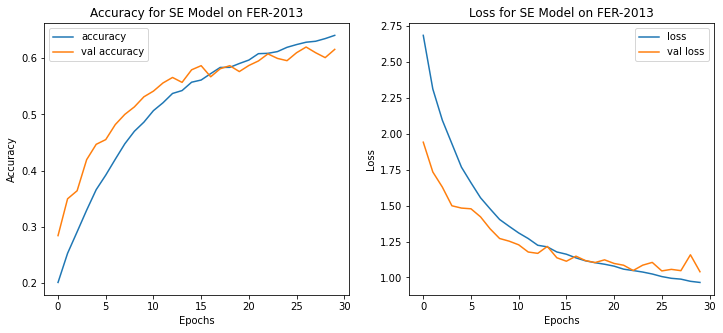

In [15]:
se_accuracy = model_info.history['accuracy']
se_val_accuracy = model_info.history['val_accuracy']
se_loss = model_info.history['loss']
se_val_loss = model_info.history['val_loss']

plt.figure(figsize=(12, 5))

# accuracy graph
plt.subplot(1, 2, 1)
plt.plot(se_accuracy, label='accuracy')
plt.plot(se_val_accuracy, label='val accuracy')
plt.title('Accuracy for SE Model on FER-2013')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# loss graph
plt.subplot(1, 2, 2)
plt.plot(se_loss, label='loss')
plt.plot(se_val_loss, label='val loss')
plt.title('Loss for SE Model on FER-2013')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()